In [247]:
import pandas as pd
import numpy as np
from alpha_vantage.timeseries import TimeSeries
import requests
import matplotlib.pyplot as plt
import yfinance as yf
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import scipy.stats as st


In [248]:
class ModelARIMA():


      def __init__(self) -> None:
            pass


      def hyndman_khandakar(self, series):
            auto_model = auto_arima(series)
            #forecast, conf_int = auto_model.predict(n_periods=1, return_conf_int=True, alpha=0.05)
            #conf_int = conf_int[0]
            order = list(auto_model.order)
            seasonal_order = list(auto_model.seasonal_order)
            parameters = []
            parameters.append(order)
            parameters.append(seasonal_order)
            return parameters


      def check_stationarity(self, data):
            result = adfuller(data)
            if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
                  return True
            else:
                  return False


      def get_parameters(self, data):
            close_p = data["Close"]

            is_data_stationary = self.check_stationarity(close_p)
            while is_data_stationary == False:
                  close_p = close_p.diff()
                  close_p = close_p.dropna()
                  is_data_stationary = self.check_stationarity(close_p)

            parameters = self.hyndman_khandakar(close_p)
            return parameters
      
      def get_innovation_std_dev(self, data):
            close_p = data["Close"]

            is_data_stationary = self.check_stationarity(close_p)
            while is_data_stationary == False:
                  close_p = close_p.diff()
                  close_p = close_p.dropna()
                  is_data_stationary = self.check_stationarity(close_p)

            parameters = self.hyndman_khandakar(close_p)
            order = tuple(parameters[0])
            seasonal_order = tuple(parameters[1])
            model = sm.tsa.statespace.SARIMAX(close_p, order=order, seasonal_order=seasonal_order, trend="c")
            fitted = model.fit(disp=False)

            #sigma_hat = fitted.scale**0.5
            sigma_hat = fitted.resid.std(ddof=1)
            alpha = 0.05
            z = st.norm.ppf(1 - alpha/2)
            delta = z * sigma_hat

            return delta


    

In [249]:
ALPHA_VANTAGE_API_KEY = "6JKWIK2RFT5121M1"

ts = TimeSeries(key=ALPHA_VANTAGE_API_KEY, output_format="pandas")

In [291]:
ticker = "CMG"

data, meta_data = ts.get_daily(
    symbol=ticker,
    outputsize="full" #  returns full history (compact = last 100 days)
)

data = data.reset_index()
data = data.rename(columns={
    "date": "Date",
    "1. open": "Open",
    "2. high": "High",
    "3. low": "Low",
    "4. close": "Close",
    "5. volume": "Volume"
})

data = data.sort_values(by="Date")
data = data.reset_index()
data = data.drop(columns=["index"])

#data["50_day_MA"] = data["Close"].rolling(window=50).mean() # 50-days Moving average
#data["100_day_MA"] = data["Close"].rolling(window=100).mean() # 100-days Moving average
#data["Log_return"] = np.log(data["Close"] / data["Close"].shift(1)) # Daily log returns
# Annualized daily volatility computed from rolling standard deviation of 20 days 
#data["Volatility"] = data["Log_return"].rolling(window=20).std() * np.sqrt(252)  

ten_years_ago = pd.Timestamp.today() - pd.DateOffset(years=10)
data = data[data["Date"] >= ten_years_ago]

data

,Date,Open,High,Low,Close,Volume
2413,2015-08-27,714.00,730.00,710.2436,727.17,583845.0
2414,2015-08-28,725.00,728.17,717.0900,721.20,235579.0
2415,2015-08-31,719.79,722.10,707.5000,710.01,464595.0
2416,2015-09-01,697.73,714.19,696.1000,706.71,409422.0
2417,2015-09-02,713.69,724.00,710.5800,723.87,374277.0
...,...,...,...,...,...,...
4921,2025-08-19,43.50,43.77,42.9200,43.25,19153745.0
4922,2025-08-20,43.21,43.99,43.0000,43.07,12488090.0
4923,2025-08-21,42.95,43.10,42.5400,42.91,11193664.0
4924,2025-08-22,43.33,43.72,43.0700,43.64,10912848.0


In [292]:
data["Date"] = data["Date"].dt.tz_localize("America/New_York")

# Getting splits for researched asset from Yahoo Finance and selecting
# only the splits that apply to considered observational period, i.e.,
# the last 10 years
splits = yf.Ticker(ticker).splits
splits = splits[splits.index > data["Date"].min()]
splits

Date
2024-06-26 00:00:00-04:00    50.0
Name: Stock Splits, dtype: float64

In [293]:
# If there are some such splits
if splits.shape[0] > 0:
    factor = 1
    for date, ratio in splits.items():
        factor *= ratio
        data.loc[data["Date"] < date, "Adjustment_factor"] = factor

    # For dates for which no split applied, dates after the last split, there is
    # no adjustment factor, factor of 1, that doesn't change stock's prices, is added.
    data.loc[data["Adjustment_factor"].isna(), "Adjustment_factor"] = 1

    # Stock prices are adjusted based on the adjustment factor that says how many new
    # shares were created from the old previous one
    data["Close_adjusted"] = data["Close"] * (1 / data["Adjustment_factor"])

    # If there were splits, 50-days, 100-days Moving Averages, 
    # and log returns are calculated from adjusted prices
    data["50_day_MA"] = data["Close_adjusted"].rolling(window=50).mean() # 50-days Moving average
    data["100_day_MA"] = data["Close_adjusted"].rolling(window=100).mean() # 100-days Moving average
    data["Log_return"] = np.log(data["Close_adjusted"] / data["Close_adjusted"].shift(1)) # Daily log returns
    # Annualized daily volatility computed from rolling standard deviation of 20 days 
    data["Volatility"] = data["Log_return"].rolling(window=20).std() * np.sqrt(252)
else:
    # If there were no splits, 50-days, 100-days Moving Averages, and log returns are calculated 
    # from the original closing prices data
    data["50_day_MA"] = data["Close"].rolling(window=50).mean() # 50-days Moving average
    data["100_day_MA"] = data["Close"].rolling(window=100).mean() # 100-days Moving average
    data["Log_return"] = np.log(data["Close"] / data["Close"].shift(1)) # Daily log returns
    # Annualized daily volatility computed from rolling standard deviation of 20 days 
    data["Volatility"] = data["Log_return"].rolling(window=20).std() * np.sqrt(252)  

data

,Date,Open,High,Low,Close,Volume,Adjustment_factor,Close_adjusted,50_day_MA,100_day_MA,Log_return,Volatility
2413,2015-08-27 00:00:00-04:00,714.00,730.00,710.2436,727.17,583845.0,50.0,14.5434,NaN,NaN,NaN,NaN
2414,2015-08-28 00:00:00-04:00,725.00,728.17,717.0900,721.20,235579.0,50.0,14.4240,NaN,NaN,-0.008244,NaN
2415,2015-08-31 00:00:00-04:00,719.79,722.10,707.5000,710.01,464595.0,50.0,14.2002,NaN,NaN,-0.015637,NaN
2416,2015-09-01 00:00:00-04:00,697.73,714.19,696.1000,706.71,409422.0,50.0,14.1342,NaN,NaN,-0.004659,NaN
2417,2015-09-02 00:00:00-04:00,713.69,724.00,710.5800,723.87,374277.0,50.0,14.4774,NaN,NaN,0.023991,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4921,2025-08-19 00:00:00-04:00,43.50,43.77,42.9200,43.25,19153745.0,1.0,43.2500,49.9164,50.0887,-0.003001,0.569652
4922,2025-08-20 00:00:00-04:00,43.21,43.99,43.0000,43.07,12488090.0,1.0,43.0700,49.7552,50.0102,-0.004171,0.566465
4923,2025-08-21 00:00:00-04:00,42.95,43.10,42.5400,42.91,11193664.0,1.0,42.9100,49.6010,49.9402,-0.003722,0.271936
4924,2025-08-22 00:00:00-04:00,43.33,43.72,43.0700,43.64,10912848.0,1.0,43.6400,49.4380,49.8745,0.016869,0.266110


In [294]:
url = f"https://www.alphavantage.co/query?function=TREASURY_YIELD&interval=daily&maturity=10year&apikey={ALPHA_VANTAGE_API_KEY}"

response = requests.get(url)
risk_free_rate_data = response.json()

# At this point, the unit is percent and interval is daily
risk_free_rate_data = pd.DataFrame(risk_free_rate_data["data"])

risk_free_rate_data = risk_free_rate_data.rename(columns={
    "date": "Date",
    "value": "Value"
})

risk_free_rate_data = risk_free_rate_data.sort_values(by="Date")
risk_free_rate_data = risk_free_rate_data.reset_index()
risk_free_rate_data = risk_free_rate_data.drop(columns="index")

# This changes string values of Value column to numbers only if possible and divide by 100 to get the
# percentage values as a fraction of 1
risk_free_rate_data["Value"] = pd.to_numeric(risk_free_rate_data["Value"], errors="coerce") / 100
risk_free_rate_data["Date"] = pd.to_datetime(risk_free_rate_data["Date"], errors="coerce")

# The U.S. Department of Treasury posts rates daily on business days, however, for weekends and holidays
# the rates stay unchanged, therefore ->
# This will replace each missing value (NaN) with the most recent previous non-missing value
risk_free_rate_data["Value"] = risk_free_rate_data["Value"].ffill()

ten_years_risk_free_rate_data = risk_free_rate_data[risk_free_rate_data["Date"] >= ten_years_ago]

ten_years_risk_free_rate_data

,Date,Value
13997,2015-08-27,0.0218
13998,2015-08-28,0.0219
13999,2015-08-31,0.0221
14000,2015-09-01,0.0217
14001,2015-09-02,0.0220
...,...,...
16599,2025-08-18,0.0434
16600,2025-08-19,0.0430
16601,2025-08-20,0.0429
16602,2025-08-21,0.0433


In [295]:
ten_years_risk_free_rate_data["Date"] = ten_years_risk_free_rate_data["Date"].dt.tz_localize("America/New_York")

merged_data = pd.merge(data, ten_years_risk_free_rate_data, on="Date", how="inner")
merged_data = merged_data.rename(columns={"Value": "Risk-free Rate"})

if "Close_adjusted" in merged_data.columns:
    merged_data["Close"] = merged_data["Close_adjusted"]
    merged_data = merged_data.drop("Close_adjusted", axis=1)
    
merged_data["Date"] = merged_data["Date"].dt.tz_localize(None)
merged_data

/var/folders/0k/vksjbls10m9f1y5tjj3t5gh40000gn/T/ipykernel_18956/233522360.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ten_years_risk_free_rate_data["Date"] = ten_years_risk_free_rate_data["Date"].dt.tz_localize("America/New_York")


,Date,Open,High,Low,Close,Volume,Adjustment_factor,50_day_MA,100_day_MA,Log_return,Volatility,Risk-free Rate
0,2015-08-27,714.00,730.00,710.2436,14.5434,583845.0,50.0,NaN,NaN,NaN,NaN,0.0218
1,2015-08-28,725.00,728.17,717.0900,14.4240,235579.0,50.0,NaN,NaN,-0.008244,NaN,0.0219
2,2015-08-31,719.79,722.10,707.5000,14.2002,464595.0,50.0,NaN,NaN,-0.015637,NaN,0.0221
3,2015-09-01,697.73,714.19,696.1000,14.1342,409422.0,50.0,NaN,NaN,-0.004659,NaN,0.0217
4,2015-09-02,713.69,724.00,710.5800,14.4774,374277.0,50.0,NaN,NaN,0.023991,NaN,0.0220
...,...,...,...,...,...,...,...,...,...,...,...,...
2507,2025-08-18,43.98,44.27,43.3600,43.3800,18105552.0,1.0,50.1014,50.1569,-0.015100,0.569902,0.0434
2508,2025-08-19,43.50,43.77,42.9200,43.2500,19153745.0,1.0,49.9164,50.0887,-0.003001,0.569652,0.0430
2509,2025-08-20,43.21,43.99,43.0000,43.0700,12488090.0,1.0,49.7552,50.0102,-0.004171,0.566465,0.0429
2510,2025-08-21,42.95,43.10,42.5400,42.9100,11193664.0,1.0,49.6010,49.9402,-0.003722,0.271936,0.0433


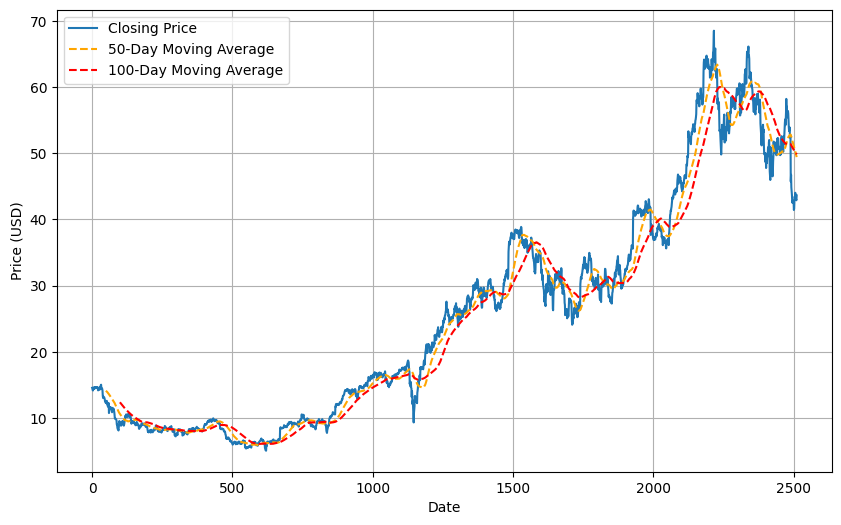

In [296]:
plt.figure(figsize=(10, 6))
plt.plot(merged_data["Close"], label="Closing Price")
plt.plot(merged_data["50_day_MA"], label="50-Day Moving Average", color="orange", linestyle="--")
plt.plot(merged_data["100_day_MA"], label="100-Day Moving Average", color="red", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid()
plt.show()

In [297]:
merged_data.to_csv(f"./../data/{ticker.lower()}_data.csv")

FINDING ASSET'S PARAMETERS AND ADDING THEM INTO FILE OF OBSERVED ASSETS

In [298]:
model = ModelARIMA()
delta = model.get_innovation_std_dev(merged_data)
delta = round(delta)

if delta < 2:
    delta = 2

delta

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


2

In [299]:
observed_assets = pd.read_csv("./../data/observed_assets.csv", sep=",")
observed_assets.loc[len(observed_assets)] = [ticker, delta]
observed_assets.to_csv("./../data/observed_assets.csv", sep=",", index=False)